In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
import numpy as np

In [2]:
train_data = datasets.MNIST(root="MNIST", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="MNIST", train=False, download=True, transform=ToTensor())

In [3]:
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size)
val_dataloader = DataLoader(val_dataset, batch_size)
test_dataloader = DataLoader(test_data, batch_size)

In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(device)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model=NeuralNetwork().to(device)
print(model)

cuda
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.007)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred=model(X)
        loss=loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"Loss: {loss:>7f} [{current:>5d} / {size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss/=num_batches
        correct/=size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Prediction before training

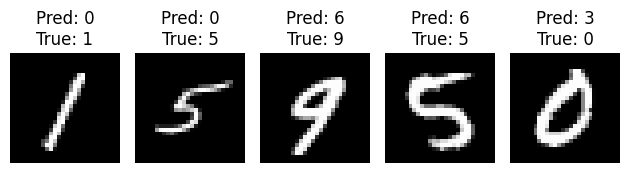

In [8]:
import matplotlib.pyplot as plt

def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, val_dataset)

In [9]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done")

Epoch 1
--------------------
Loss: 2.298285 [   64 / 48000]
Loss: 2.291156 [ 6464 / 48000]
Loss: 2.280152 [12864 / 48000]
Loss: 2.273805 [19264 / 48000]
Loss: 2.251464 [25664 / 48000]
Loss: 2.238404 [32064 / 48000]
Loss: 2.213149 [38464 / 48000]
Loss: 2.160478 [44864 / 48000]
Test Error: 
 Accuracy: 65.2%, Avg loss: 2.130055 

Epoch 2
--------------------
Loss: 2.112439 [   64 / 48000]
Loss: 2.060161 [ 6464 / 48000]
Loss: 1.874045 [12864 / 48000]
Loss: 1.697750 [19264 / 48000]
Loss: 1.459843 [25664 / 48000]
Loss: 1.300261 [32064 / 48000]
Loss: 1.138648 [38464 / 48000]
Loss: 0.918905 [44864 / 48000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.866234 

Epoch 3
--------------------
Loss: 0.949888 [   64 / 48000]
Loss: 0.980715 [ 6464 / 48000]
Loss: 0.740353 [12864 / 48000]
Loss: 0.695234 [19264 / 48000]
Loss: 0.625842 [25664 / 48000]
Loss: 0.632647 [32064 / 48000]
Loss: 0.574533 [38464 / 48000]
Loss: 0.439857 [44864 / 48000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.498256 

Epoch 4
-----

In [10]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.248851 



# Prediction after training

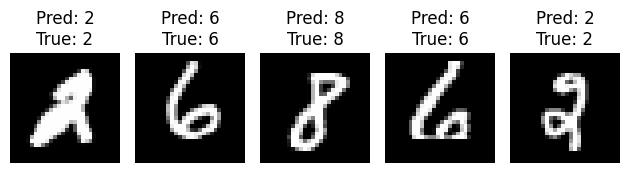

In [ ]:
import matplotlib.pyplot as plt

def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, val_dataset)